# PS reconstruction, Gaussian beam

In [1]:
import torch
import numpy as np

from phase_space_reconstruction.visualization import plot_projections

from cheetah.particles import ParticleBeam
from cheetah.utils.bmadx import bmad_to_cheetah_coords

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
p0c = 43.36e6 # reference momentum in eV/c

particle_data = torch.load("data/gaussian_beam.pt").data[:10000]
bmad_gt_beam = torch.load("data/gaussian_beam.pt")
bmad_gt_beam.data = bmad_gt_beam.data[:10000]

particle_data = bmad_to_cheetah_coords(
    particle_data,
    torch.tensor(p0c),
    torch.tensor(0.511e6)
)
gt_beam = ParticleBeam(*particle_data)


## Define diagnostics lattice parameters

In [3]:
# triplet params obtained from triplet-opt.ipynb
#k1 =            -39.160589
#k2 =             25.787117
#k3 =            -25.667133

k1 =            -24.868402
k2 =             26.179029
k3 =            -26.782126

## Bmadx version for benchmarking

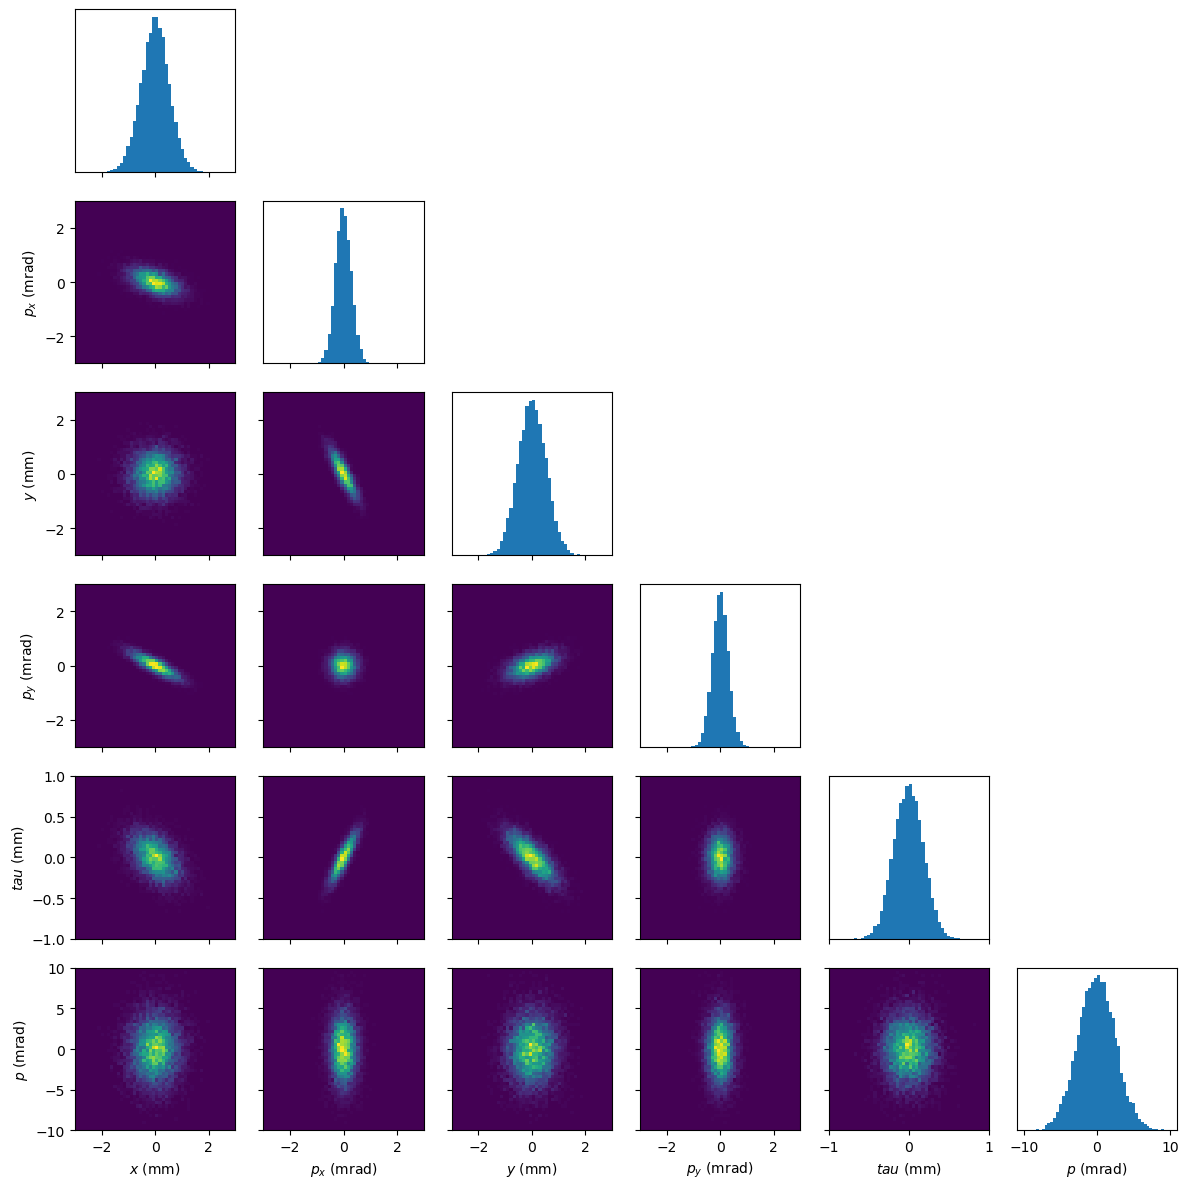

In [4]:
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-5e-3, 5e-3],
                 [-5e-2, 5e-2]]) *0.2
fig, ax = plot_projections(
    gt_beam,
    custom_lims = lims,
)

C:\Users\Ryan Roussel\mambaforge\envs\phase_space_reconstruction\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([200, 200])


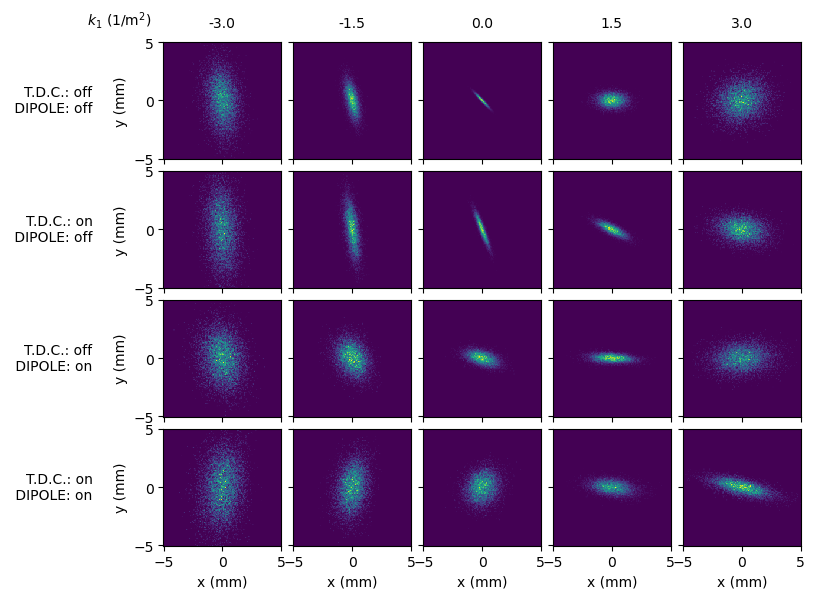

In [5]:
from phase_space_reconstruction.legacy.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.legacy.scans import run_awa_3d_scan
from phase_space_reconstruction.legacy.visualization import plot_3d_scan_data
from phase_space_reconstruction.diagnostics import ImageDiagnostic

# diagnostic beamline:
blattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
blattice.elements[0].K1.data = torch.tensor(k1)
blattice.elements[2].K1.data = torch.tensor(k2)
blattice.elements[4].K1.data = torch.tensor(k3)

# create diagnostic screens:
bins = torch.linspace(-5, 5, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(
    bins, bins, bandwidth
)

# Scan over quad strength, tdc on/off and dipole on/off
n_ks = 5
PI = 3.14
ks = torch.linspace(-3, 3, n_ks) # quad ks
vs = torch.tensor([0, 3e6]) # TDC off/on
gs = torch.tensor([-2.22e-16, -20.0*PI/180.0/0.365]) # dipole off/on

scan_ids = [6, 8, 10]
n_ks = 5
train_dset_3d_scan = run_awa_3d_scan(
    bmad_gt_beam,
    blattice,
    screen,
    ks, vs, gs,
    ids = scan_ids,
    )
fig, ax = plot_3d_scan_data(train_dset_3d_scan, bins, publication_size=True)



Cheetah based version

In [6]:
# define upstream beamline
from cheetah.accelerator import Quadrupole, Drift
from copy import deepcopy

quad_length = 0.11
lq12 = 1.209548
lq23 = 0.19685
lq34 = 0.18415
ld1 = lq12 - quad_length
ld2 = lq23 - quad_length
ld3 = lq34 - quad_length
q1 = Quadrupole(
    length=quad_length,
    k1=k1,
    num_steps=5,
    tracking_method="bmadx"
)
d1 = Drift(ld1)
q2 = Quadrupole(
    length=quad_length,
    k1=k2,
    num_steps=5,
    tracking_method="bmadx"
)
d2 = Drift(ld2)
q3 = Quadrupole(
    length=quad_length,
    k1=k3,
    num_steps=5,
    tracking_method="bmadx"
)
d3 = Drift(ld3)
upstream_components = [q1, d1, q2, d2, q3, d3]

from phase_space_reconstruction.modeling import GPSR6DLattice

l_quad=0.11
l_tdc=0.01
f_tdc=1.3e9
phi_tdc=0.0
l_bend=0.3018
theta_on=- 20.0 * 3.14 / 180.0
l1=0.790702
l2=0.631698
l3=0.889

gpsr_lattice = GPSR6DLattice(
    l_quad,
    l_tdc,
    f_tdc,
    phi_tdc,
    l_bend,
    theta_on,
    l1,
    l2,
    l3,
    deepcopy(screen),
    deepcopy(screen),
    upstream_components
)



train_params = torch.meshgrid(gs, vs, ks, indexing='ij')
train_params = torch.stack(train_params, dim=-1)
print(train_params.shape)

# create training data
gpsr_lattice.set_lattice_parameters(train_params)
final_beam = gpsr_lattice.lattice(gt_beam)
obs = gpsr_lattice.track_and_observe(gt_beam)

#obs[0].shape


C:\Users\Ryan Roussel\mambaforge\envs\phase_space_reconstruction\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


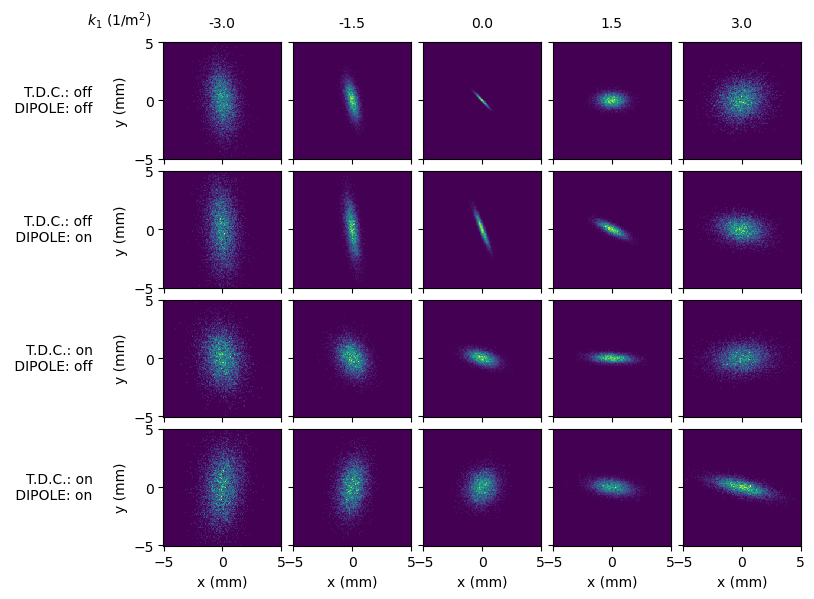

In [7]:
from phase_space_reconstruction.datasets import SixDReconstructionDataset
obs_dataset = SixDReconstructionDataset(train_params, obs, (bins, bins))

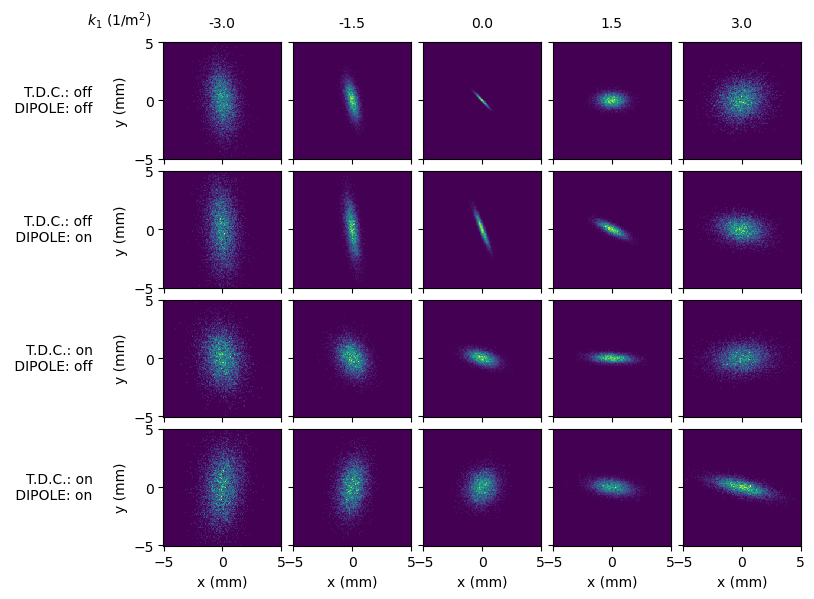

In [8]:
fig, ax = obs_dataset.plot_data(publication_size=True)

## Training using pytorch lightning

In [9]:
import lightning as L

from phase_space_reconstruction.modeling import GPSR
from phase_space_reconstruction.train import LitGPSR
from phase_space_reconstruction.beams import NNParticleBeamGenerator

gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(obs_dataset, batch_size=20)

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type | Params
------------------------------------
0 | gpsr_model | GPSR | 1.1 K 
------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
C:\Users\Ryan Roussel\mambaforge\envs\phase_space_reconstruction\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\Ryan Roussel\mambaforge\envs\phase_space_reconstruction\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interva

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


In [10]:
litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger('.', )
trainer = L.Trainer(limit_train_batches=100,max_epochs=500, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

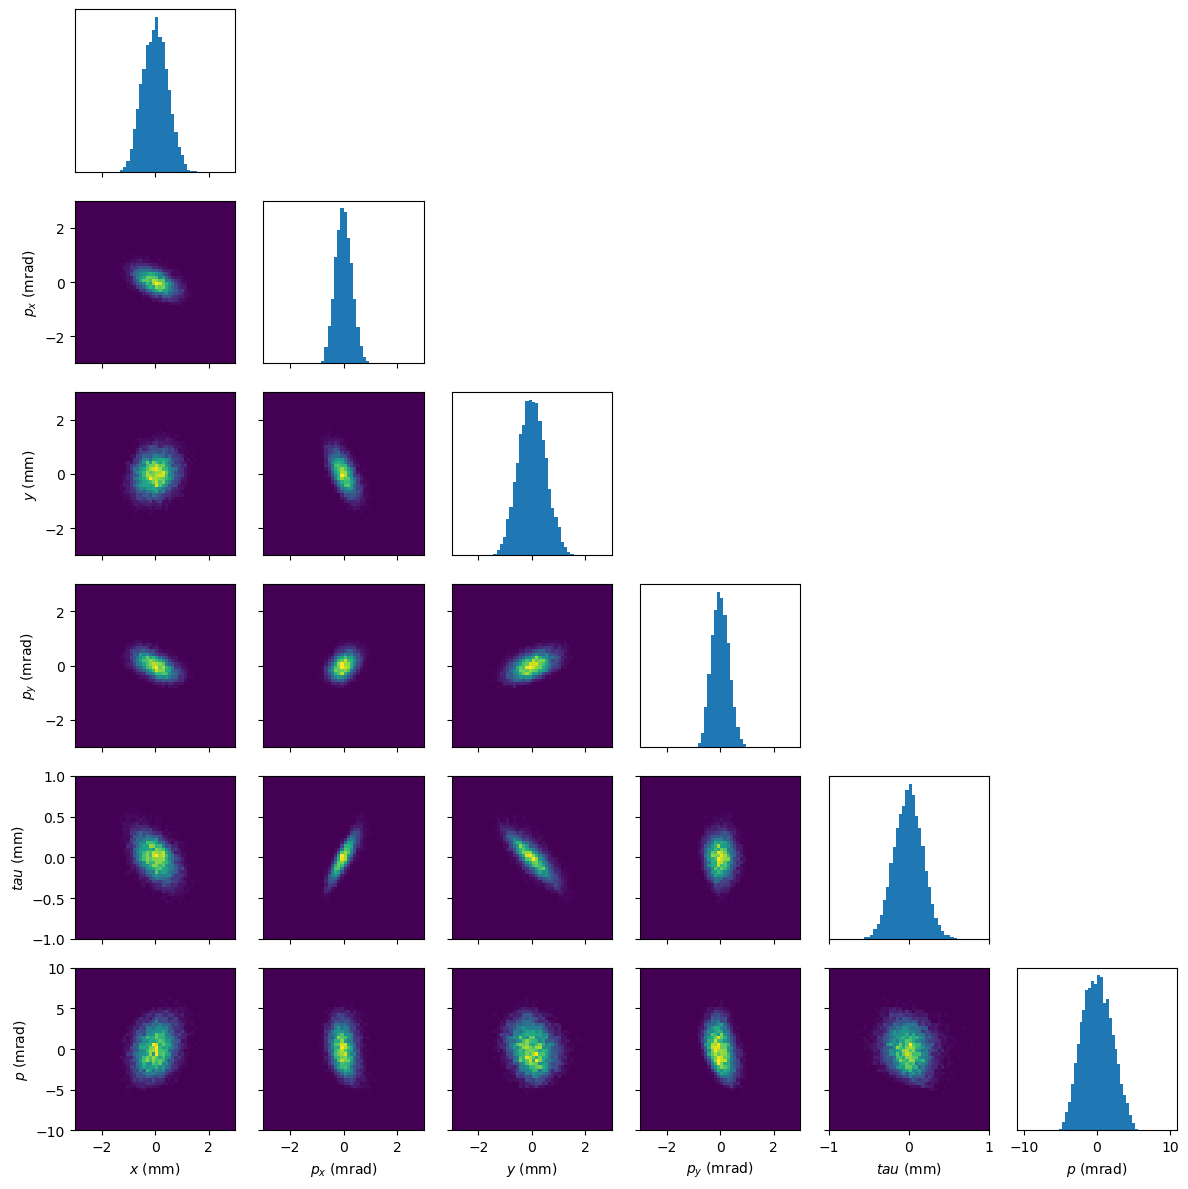

In [11]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

In [11]:

plot_projections(
    reconstructed_beam,
    custom_lims = lims,
)